Goal: Take a sample from $x_1, ..., x_n$ proportional to weights $w_1, ..., w_n$ continuously. i.e. Not a multinomial smaple

Malik and Pitt resampling:

We are assuming that we have a set of uniforms that we use
to invert the cdf $\tilde{F}(x)$ above. So, we have the set of N, sorted in ascending order, uniform variates u1 < · · · < uN . The generation of the, possibly stratified, uniforms is discussed later in this appendix.


The pseudo-algorithm given below samples the index corre- sponding to the region which are stored as r1, r2, . . . , rN , and also produces a new set of uniforms, u∗1, . . . , u∗N 

set s = 0, j = 1; for {i = 0 : N}
{
    s = s + πi;
    while(uj ≤s & j≤N){
        rj =i;
        u∗j = (uj − (s − πi))/πi 
        j=j+1
}

For the selected regions where $r^j = 0$, we set $x_j^* = x^{(1)}$ and when $r^j = N$ we set $x_j^* = x^{(N)}$. Otherwise set: 
(x(rj+1) − x(rj)) × u∗j + x(rj
$x_j^* = (x^{(r^j+1)} - x^{(r^j)}) * u_j^* + x^{(r^j)}$

### Goal:

Sample $x_1,...,x_n$ from $f(x)$ with weights $\pi_j, j=1,...,n$

In [68]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

import jax
from jax import random
import jax.numpy as jnp

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
np.random.seed(0)

N = 5
rv = norm()
x = rv.rvs(size=N)
print(x)

w = rv.pdf(x)
w = w / sum(w)
print(w)

[1.76405235 0.40015721 0.97873798 2.2408932  1.86755799]
[0.10499584 0.45934343 0.30824565 0.0404093  0.08700579]


In [3]:
x_dict = dict(zip(x, w))
print(x_dict.keys())

sorted_x_dict = dict(sorted(x_dict.items(), key = lambda x: x[0]))
sorted_x = np.array(list(sorted_x_dict.keys()))
sorted_weights = np.array(list(sorted_x_dict.values()))
sorted_x_dict

dict_keys([1.764052345967664, 0.4001572083672233, 0.9787379841057392, 2.240893199201458, 1.8675579901499675])


{0.4001572083672233: 0.45934343207532335,
 0.9787379841057392: 0.30824564791308834,
 1.764052345967664: 0.10499583727389594,
 1.8675579901499675: 0.08700578587308815,
 2.240893199201458: 0.0404092968646043}

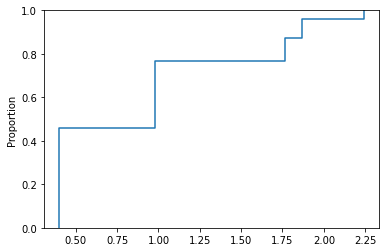

In [4]:
sns.ecdfplot(x=x, weights = w);

In [190]:
def jax_cont_resample (weights, xs, key):
    """
    Change `seed` to `key`
    """
    n = len(weights)
    u_new = jnp.zeros(n)
    u0 = random.uniform(key)
    u = (u0 + np.arange(n)) / n
    u = jnp.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
    
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2
    
    def region_mid (k, val):
        xs = val["x"]
        r = val["r"]
        u_new = val["u_new"]
        return (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    
    def while_loop_func (val):
        u_j = val["u"][val["j"]]
        pi_i = val["pi"][val["i"]]
        
        val["r"] = val["r"].at[val["j"]].set(val["i"])
        val["u_new"] = val["u_new"].at[val["j"]].set((u_j - (val["s"] - pi_i)) / pi_i)
        
        # select region: 
        new_x = jax.lax.cond(
            val["r"][val["j"]] == 0,
            lambda _: val["x"][0],
            lambda _: jax.lax.cond(
                val["r"][val["j"]] == n,
                lambda _: val["x"][-1],
                lambda _: region_mid(val["j"], val),
                val
            ),
            val
        )
        val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
        val["j"] += 1
        return val 

    def while_cond (val):
        return jnp.logical_and(val["j"] <= n, val["u"][val["j"]] <= val["s"])
    
    def for_loop_func (i, val):
        val["s"] += val["pi"][i]
        val["i"] = i
        val = jax.lax.while_loop(while_cond, while_loop_func, val)
        return val
 
    init_val = {
        "j": 0,
        "r": jnp.zeros(n, int),
        "s": 0,
        "i": 0,
        "u": u,
        "u_new": jnp.zeros(n),
        "x": xs,
        "x_new": jnp.zeros(n),
        "pi": pi}
    
    val = jax.lax.fori_loop(0, n, for_loop_func, init_val)

    # select region: 
    new_x = jax.lax.cond(
        val["r"][val["j"]] == 0,
        lambda _: val["x"][0],
        lambda _: jax.lax.cond(
            val["r"][val["j"]] == n,
            lambda _: val["x"][-1],
            lambda _: region_mid(val["j"], val),
            val
        ),
        val
    )
    val["x_new"] = val["x_new"].at[val["j"]].set(new_x)
    
    return val["x_new"]

In [191]:
def continuous_stratified_resample(weights, xs):
    """
    Args: 
        - weights: normalized weights with indices corresponding to xs. This is represented by \pi in the paper
        - xs: samples sorted in ascending order. Represented by x^{(k)} in the paper. 

    """
    n = len(weights)
    u0 = np.random.uniform(size=1)
    u = (u0 + np.arange(n)) / n
    u = np.array([0.14303787, 0.34303787, 0.54303787, 0.74303787, 0.94303787])
#     print(u)
    
    # A.1: general form of continuous distribution
    pi = np.zeros(n + 1)
    pi[0] = weights[0] / 2
    pi[n] = weights[-1] / 2
    pi[1:n] = (weights[:-1] + weights[1:]) / 2

    # A.3
    r = np.zeros(n)
    u_new = np.zeros(n)
    s = 0
    j = 1

    for i in range(n + 1):
        s = s + pi[i]
        while(j <= n and u[j - 1] <= s):
            r[j - 1] = i
            u_new[j - 1] = (u[j - 1] - (s - pi[i])) / pi[i]
            j = j + 1

    r = r.astype(int)

    x_new = np.zeros(n)
    for k in range(n):
        if r[k] == 0:
            x_new[k] = xs[0]
        elif r[k] == n:
            x_new[k] = xs[-1]
        else:
            x_new[k] = (xs[r[k]] - xs[r[k] - 1]) * u_new[k] + xs[r[k] - 1]
    return x_new

In [194]:
print("Numpy version (fixed U): ", continuous_stratified_resample(sorted_weights, sorted_x))

print("JAX version (fixed U): ", jax_cont_resample(jnp.array(sorted_weights), 
                                                   jnp.array(sorted_x), 
                                                   key = random.PRNGKey(0)))

Numpy version (fixed U):  [0.40015721 0.57105979 0.87256526 1.47120766 2.02548915]
JAX version (fixed U):  [0.4001572 0.5710598 0.8725653 1.4712076 2.025489 ]


In [196]:
x_new_samples = [continuous_stratified_resample(sorted_weights, sorted_x) for i in range(200)]
x_new_samples = np.array(x_new_samples).flatten()

sns.ecdfplot(x=x_new_samples, alpha=0.8, color='firebrick').set(title = 'numpy continuous CDF')
sns.ecdfplot(x=x, weights = w);

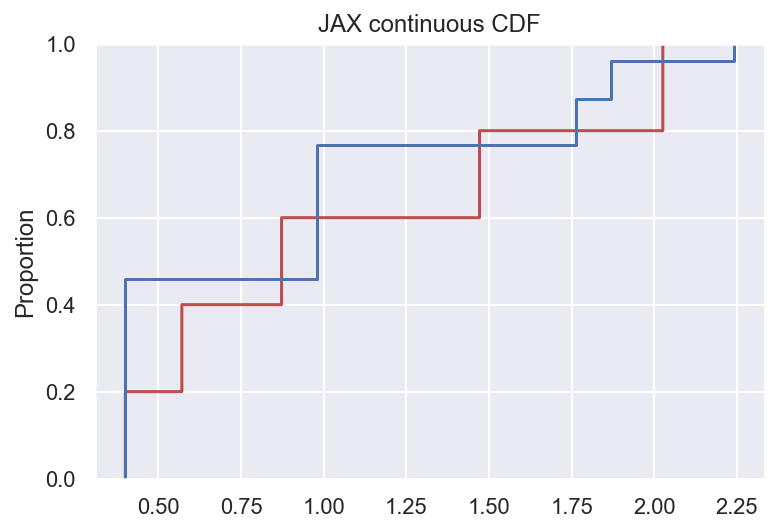

In [198]:
keys = jax.random.split(random.PRNGKey(0), 200)
jax_x_new_samples = [jax_cont_resample(sorted_weights, sorted_x, key = keys[i]) for i in range(200)]
jax_x_new_samples = np.array(jax_x_new_samples).flatten()

sns.ecdfplot(x=jax_x_new_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);

In [185]:
@jax.jit
def continuous_cdf (xs, weights, u):
    """
    Return one sample from a continuous approximation of the ECDF of x.
    
    Should bbe trivial to extend to multiple samples if needed by: 
        list(map(lambda x: np.argmax(w_cdf > x), u))
        
    """
    n = len(weights)
    
    pi = jnp.zeros(n + 1)
    pi = pi.at[0].set(weights[0] / 2)
    pi = pi.at[n].set(weights[-1] / 2)
    pi = pi.at[1:n].set((weights[:-1] + weights[1:]) / 2)
    
    w_cdf = jnp.cumsum(pi)
    r = np.argmax(w_cdf > u)
    u_new = (u - w_cdf[r-1]) / pi[r]
    
    # select region: 
    new_x = jax.lax.cond(
        r == 0,
        lambda _: xs[0],
        lambda _: jax.lax.cond(
            r == n,
            lambda _: xs[-1],
            lambda _: (xs[r] - xs[r-1]) * u_new + xs[r-1],
            r
        ),
        r
    )
    return new_x

In [200]:
%%time
sorted_x_jnp = jnp.array(sorted_x)
jnp_sorted_weights = jnp.array(sorted_weights)
U = random.uniform(random.PRNGKey(0), shape = (100_000,))

jax_samples = jax.vmap(
    continuous_cdf,
    in_axes= (None, None, 0)
)(sorted_x_jnp, jnp_sorted_weights, U)
jax_samples

CPU times: user 343 ms, sys: 8.89 ms, total: 352 ms
Wall time: 375 ms


DeviceArray([0.48412442, 0.5483065 , 1.3146126 , ..., 0.4001572 ,
             1.9391823 , 0.8222655 ], dtype=float32)

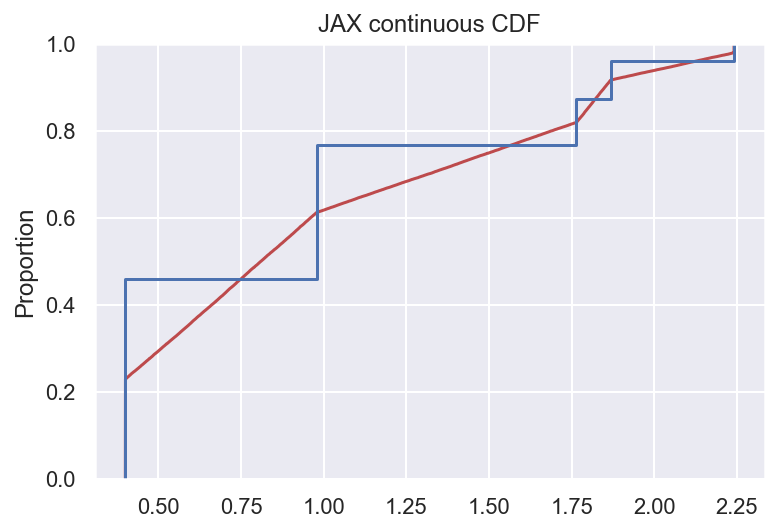

In [201]:
sns.ecdfplot(x=jax_samples, alpha=0.8, color='firebrick').set(title = 'JAX continuous CDF')
sns.ecdfplot(x=x, weights = w);